In [ ]:
import pickle
import numpy as np
import nltk
import re
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
#@title Default title text
def tokenize(X):
  """
  Tokenize the data using nltk
  """

  treebank = nltk.tokenize.TreebankWordTokenizer()
  X_tokenized=[treebank.tokenize(sentence) for sentence in X]  
  return X_tokenized

In [ ]:
def remove_noise(tweet_tokens, remove_hashtag_word=True):
    # remove hyperlinks, special characters, emojis, punctuations
    
    for i in range(len(tweet_tokens)):
        tweet_tokens[i] = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                           '(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', tweet_tokens[i])
        # Remove twitter handles
        tweet_tokens[i] = re.sub("(@[A-Za-z0-9_]*)","", tweet_tokens[i])
        # make lower
        tweet_tokens[i] = tweet_tokens[i].lower()
        tweet_tokens[i] = re.sub('rt', '', tweet_tokens[i])
        tweet_tokens[i] = re.sub('[^\w\s]', '', tweet_tokens[i])

        if remove_hashtag_word:
          pass
    return tweet_tokens

In [ ]:
def get_wordnet_pos(treebank_tag):
        """
        return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return 'a'
        elif treebank_tag.startswith('V'):
            return 'v'
        elif treebank_tag.startswith('N'):
            return 'n'
        elif treebank_tag.startswith('R'):
            return 'r'
        else:
            return 'n'


def lemmatize(X):
  """
  Lemmatize words using corresponding POS tag
  """

  lemmatizer = nltk.stem.WordNetLemmatizer()
  
  X_pos = []
  X_lemmatized = []

  for sentence in X :

    temp = nltk.pos_tag(sentence)
    X_pos.append(temp)  

  for sentence in X_pos :

    temp = [ lemmatizer.lemmatize(word[0],pos=get_wordnet_pos(word[1])) for word in sentence]
    X_lemmatized.append(temp)  

  return X_lemmatized

In [ ]:
with open('/content/drive/MyDrive/tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

# only for confusion matrix, else not needed
with open('/content/drive/MyDrive/fsacd_x_test.pickle', 'rb') as handle:
  X_test = pickle.load(handle)

with open('/content/drive/MyDrive/fsacd_y_test.pickle', 'rb') as handle:
  Y_test = pickle.load(handle)

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/fsact_lstm_w_neu')

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# prediction

def predict(text):
  text_list = list(text)
  text_list_clean = remove_noise(text_list)
  tokenized_text = tokenize(text_list_clean)
  lem_text = lemmatize(tokenized_text)

  clean_lem = []

  for sentence in lem_text:
    temp = " ".join(sentence)
    clean_lem.append(temp)

  ltcleanvectorized=tokenizer.texts_to_sequences(clean_lem)

  ltcleanpad = keras.preprocessing.sequence.pad_sequences(ltcleanvectorized,max_length,padding='post',
                                                         truncating='post')

  predicted = model.predict(ltcleanpad)

  return predicted

In [ ]:
max_length=30
labels = ["Negative", "Neutral", "Positive"]

In [ ]:
test_text = ["@ViratKohli is such a good guy https://t.co",
             "@Amazon will go bankrupt if they sell at such low rates with no profit ",
             "RT It is disappointing to see racism even in such day and age",
             "today %$^%#^: is my birthday!",
             "@DJSnake will be playing at India tomorrow.",
             "In other news the sky is blue",
             "Buy a coat worth 20 rupees"]

out = predict(test_text)

In [ ]:
for ans in out:
  print(labels[np.argmax(ans)])

Positive
Negative
Negative
Positive
Positive
Neutral
Neutral


In [ ]:
ref = []
for i in Y_test:
  ref.append(i[0])

In [ ]:
y_preds = model.predict(X_test)

In [ ]:
test = []
for i in y_preds:
  test.append(np.argmax(i))

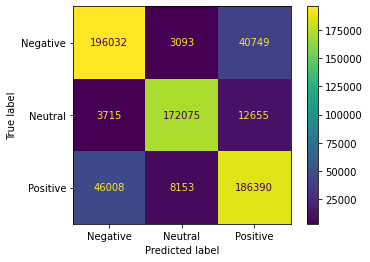

In [ ]:
# plot confusion matrix
cm = confusion_matrix(y_true = ref, y_pred=test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format='')

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision_recall_fscore_support(ref, test, labels=[0, 1, 2])

(array([0.79767248, 0.93865405, 0.77729218]),
 array([0.81722905, 0.91313115, 0.77484608]),
 array([0.80733235, 0.92571671, 0.7760672 ]),
 array([239874, 188445, 240551]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           120000000 
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               186880    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 120,195,331
Trainable params: 195,331
Non-trainable params: 120,000,000
_________________________________________________________________


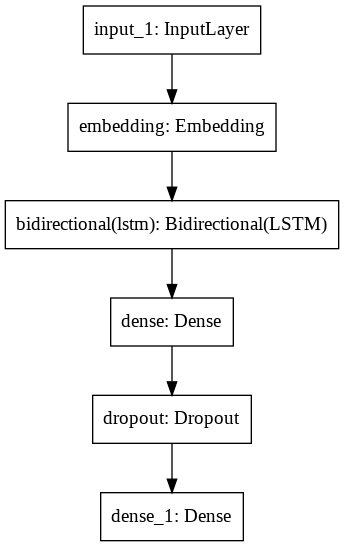

In [ ]:
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='/content/drive/MyDrive/final_sa_colab_arch.png')